# Univariate linear regression

In this section, we introduce the default PSM in `cfr` based on univariate linear regression.
It can be applied to any proxy type that is believed to have a univariate linear relationship with a certain climate variable.
It also supports a seasonality searching procedure to help determine the seasonality of a specific site.

For instance, this PSM can be applied to the `tree.MXD` records, which we believe have high linear correlation with the local temperature condition over a growing season.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np
import os

## Data preparation

### Proxy

In [2]:
df = pd.read_pickle('./data/pages2k_updated_Palmyra_dataset.pkl')
pdb = cfr.ProxyDatabase().from_df(df)

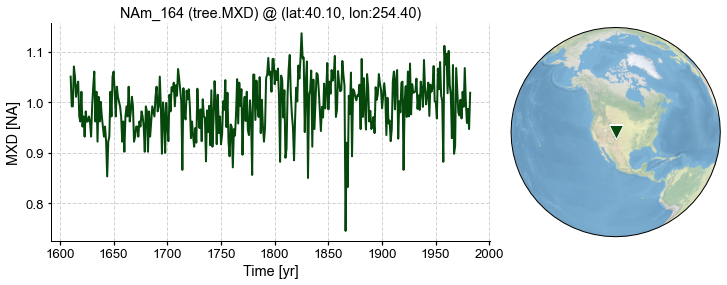

In [4]:
pobj = pdb.records['NAm_164']
fig, ax = pobj.plot()

### Model

In [4]:
dirpath = './data/'

model_tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
model_pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

In [5]:
model_tas.da

<xarray.DataArray 'tas' (time: 13872, lat: 96, lon: 144)>
[191766528 values with dtype=float32]
Coordinates:
  * time     (time) object 0850-01-17 00:00:00 ... 2005-12-17 00:00:00
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:  Reference height temperature
    units:      K

In [6]:
print(np.median(np.diff(model_tas.da.lat)))
print(np.median(np.diff(model_tas.da.lon)))

1.8947372
2.5


### Instrumental observations

In [8]:
dirpath = './data/CRUTS'

obs_tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.tmp.dat.nc'), vn='tmp')
obs_pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'cru_ts4.05.1901.2020.pre.dat.nc'), vn='pre')

In [9]:
obs_tas = obs_tas.rename('tas')
obs_pr = obs_pr.rename('pr')

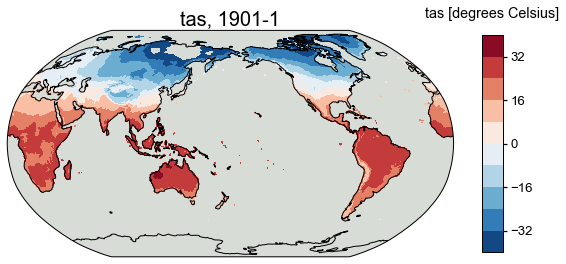

In [10]:
fig, ax = obs_tas.plot(levels=np.linspace(-40, 40, 11))

In [11]:
%%time
obs_tas_new = obs_tas.wrap_lon()

CPU times: user 1.78 s, sys: 430 ms, total: 2.21 s
Wall time: 2.25 s


In [12]:
obs_tas_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

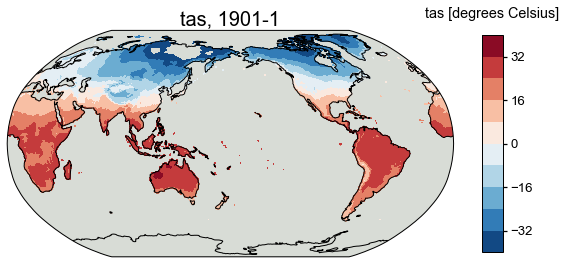

In [13]:
fig, ax = obs_tas_new.plot(levels=np.linspace(-40, 40, 11))

In [14]:
obs_pr.da.coords

Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

In [15]:
obs_pr_new = obs_pr.wrap_lon()

In [16]:
obs_pr_new.da.coords

Coordinates:
  * lon      (lon) float32 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16

## Get climate data for a specific `ProxyRecord`

In [17]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas_new, tag='obs')
pobj.get_clim(obs_pr_new, tag='obs')

CPU times: user 276 ms, sys: 3.12 s, total: 3.39 s
Wall time: 1min 29s


In [18]:
pobj.clim['obs_tas'].da

<xarray.DataArray 'tas' (time: 1440)>
array([ 0.4       ,  0.1       ,  0.5       , ..., 10.3       ,
        2.9       ,  0.90000004], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 36.25
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2020-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [19]:
lr_mdl = cfr.psm.Linear(pobj)

In [20]:
%%time
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]
lr_mdl.calibrate(season_list=sn_list)

CPU times: user 134 ms, sys: 5.69 ms, total: 139 ms
Wall time: 144 ms


In [21]:
lr_mdl.calib_details

{'df':         proxy       tas
 time                   
 1901.0  1.518  0.250000
 1902.0  1.321 -0.466667
 1903.0  1.271 -1.900000
 1904.0  1.257 -0.300000
 1905.0  1.328  0.800000
 ...       ...       ...
 1988.0  1.212 -0.266667
 1989.0  1.293 -1.400000
 1990.0  1.405 -1.100000
 1991.0  1.221 -0.333333
 1992.0  1.178 -0.466667
 
 [92 rows x 2 columns],
 'nobs': 92.0,
 'fitR2adj': 0.02479135172867819,
 'PSMresid': time
 1901.0    0.242125
 1902.0    0.075565
 1903.0    0.086444
 1904.0    0.004486
 1905.0    0.028764
             ...   
 1988.0   -0.041930
 1989.0    0.087207
 1990.0    0.186465
 1991.0   -0.030099
 1992.0   -0.067435
 Length: 92, dtype: float64,
 'PSMmse': 0.0494039726289218,
 'SNR': 0.1918727714684434,
 'seasonality': [-12, 1, 2]}

In [22]:
%%time
pp = lr_mdl.forward()

CPU times: user 74.5 ms, sys: 1.48 ms, total: 76 ms
Wall time: 77.8 ms


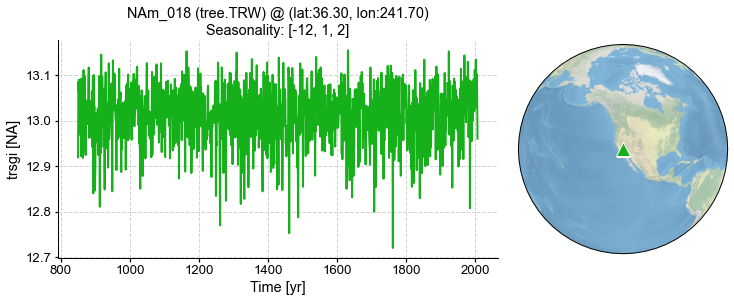

In [23]:
fig, ax = pp.plot()